In [1]:
import os
import matplotlib.pyplot as plt 
import math

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.ops import FeaturePyramidNetwork
from collections import OrderedDict

In [2]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


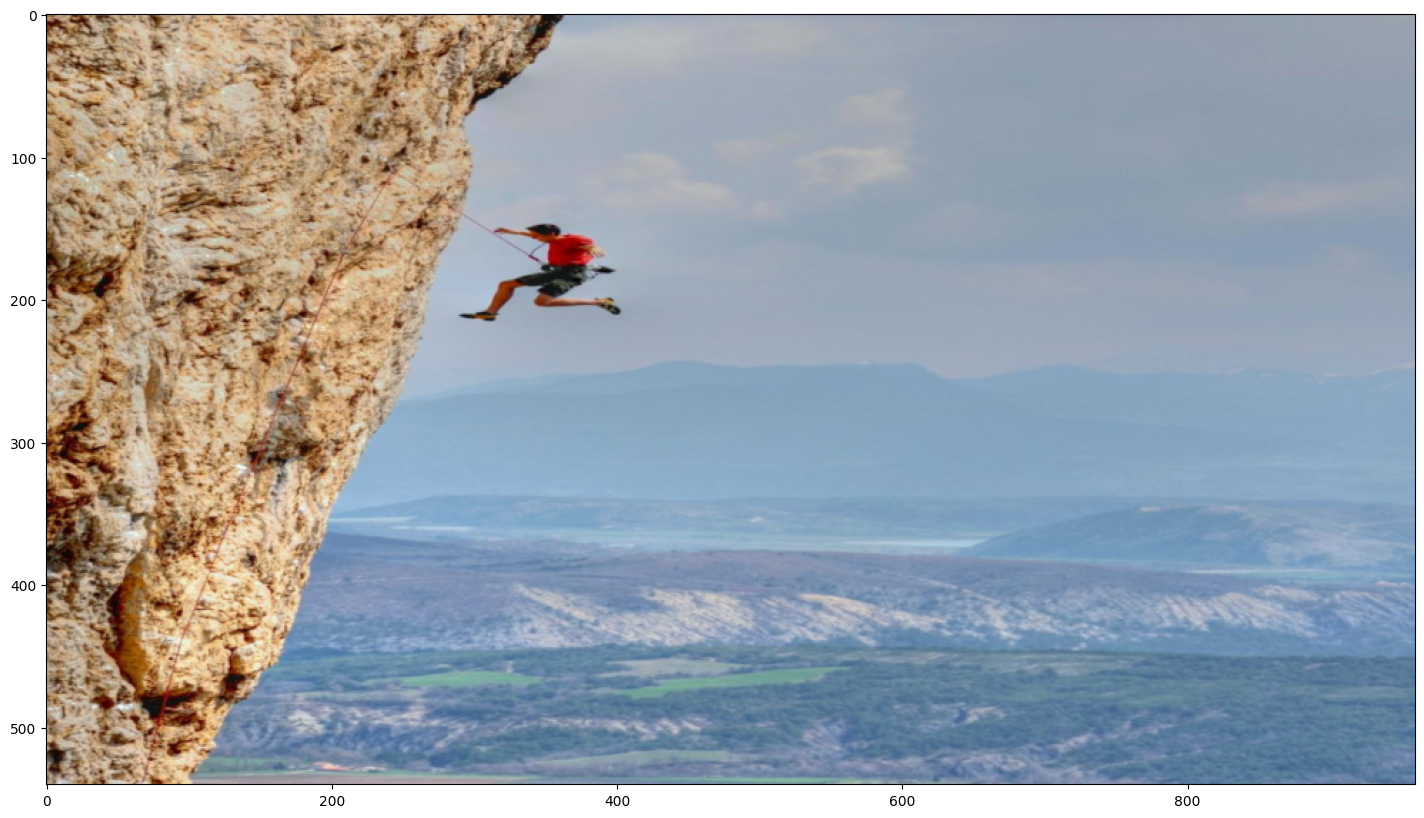

In [3]:
import torch
from torchvision import transforms
from PIL import Image

# Step 1: Load the image
image_path = "test.jpg"
image = Image.open(image_path)

# Step 2: Preprocess the image
# Define transformations (resize, normalize, convert to tensor)
transform = transforms.Compose([transforms.Resize((540, 960)), 
                                transforms.ToTensor(), 
                                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])

# Apply transformations
image = transform(image)
crop = image #[:, (image.size(1) - 1080) // 2:(image.size(1) + 1080) // 2, (image.size(2) - 1080) // 2:(image.size(2) + 1080) // 2]
plt.figure(figsize=(20,10))
plt.imshow(crop.permute(1,2,0))
plt.show()

In [4]:
def extract_patches(image, grid_size):
    # Calculate patch size
    patch_height = image.size(1) // grid_size[0]
    patch_width = image.size(2) // grid_size[1]
    return image.unfold(1, patch_height, patch_height).unfold(2, patch_width, patch_width)

# Example usage:
grid_size = (4,4)
patches = extract_patches(crop, grid_size)
print(patches.size())  # This should print torch.Size([16, patch_height, patch_width])

torch.Size([3, 4, 4, 135, 240])


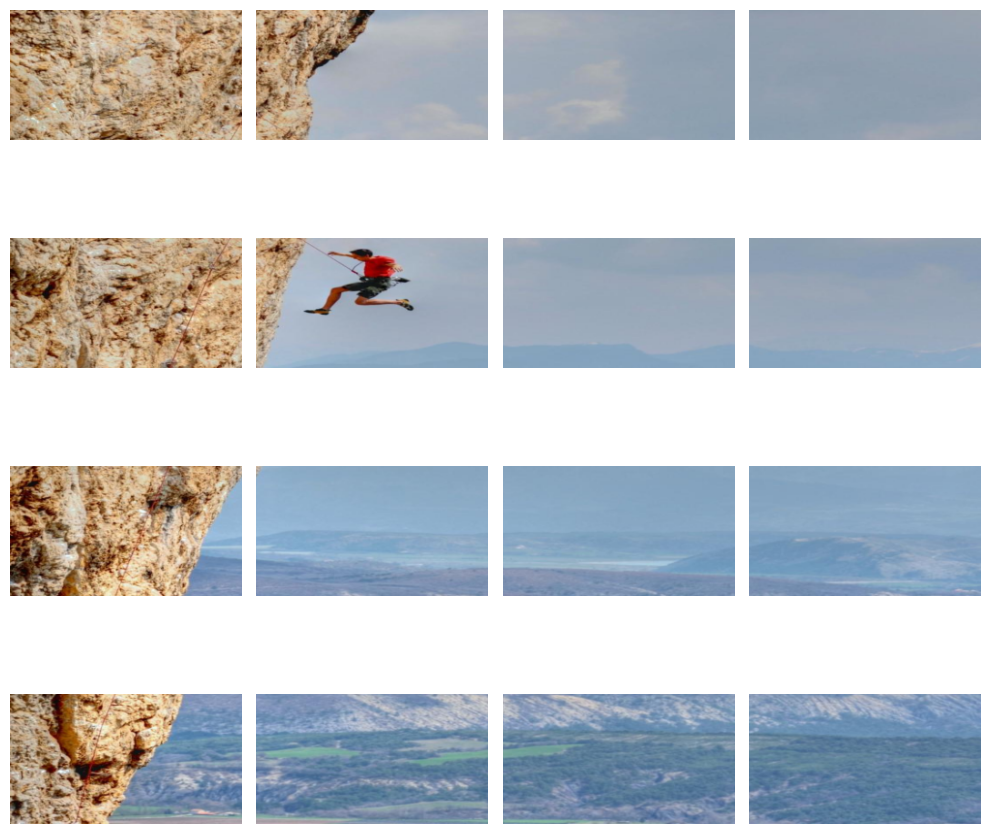

In [5]:
import matplotlib.pyplot as plt

def plot_patches(patches):
    
    patches = patches.permute(1,2,3,4,0)

    # Determine the number of rows and columns for subplots
    num_rows = patches.size(0)
    num_cols = patches.size(1)
    
    # Create a figure and axes
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    # Flatten the axes if necessary
    if((num_rows == 1) and (num_cols == 1)):
        axs = [[axs]]  # Wrap the single axes object in a nested list
    else:
        axs = axs.tolist()  # Convert the numpy array of axes objects to a list of lists

    # Plot each patch
    for row in range(num_rows):
        for col in range(num_cols):
            axs[row][col].imshow(patches[row][col]) # Assuming patches is of shape (num_patches, channels, height, width)
            axs[row][col].axis('off')  # Use axis method instead of set_axis_off

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'patches' contains the patches generated from the extract_patches function
plot_patches(patches)

In [6]:
import matplotlib.pyplot as plt

def plot_patches(grid):
    num_patches = grid.size(0)

    # Determine the number of rows and columns for subplots
    num_rows = int(num_patches**0.5)
    num_cols = (num_patches + num_rows - 1) // num_rows

    # Create a figure and axes
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    # Flatten the axes if necessary
    if num_patches == 1:
        axs = [axs]

    # Plot each patch
    for i in range(num_patches):
        row = i // num_cols
        col = i % num_cols
        axs[row][col].imshow(grid[i].permute(1, 2, 0))  # Assuming grid is of shape (num_patches, channels, height, width)
        axs[row][col].set_axis_off()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [7]:
from torch import Tensor
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [9]:
#class RegionFinder(nn.Module):
#    def __init__(self, image, x1, y1, x2, y2):
    

In [167]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [168]:
class Conv(nn.Module):
    """Standard convolution with BatchNorm and Activation"""
    def __init__(self, channelsIn, channelsOut, kernel, stride=1, padding=0, groups=1, activation=True):
        super().__init__()
        self.conv = nn.Conv2d(channelsIn, channelsOut, kernel, stride, groups=groups, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(channelsOut)
        self.act = nn.SiLU()
        self.activation = activation

    def forward(self, x):
        if(self.activation):
            return self.act(self.bn(self.conv(x)))
        else:
            return self.bn(self.conv(x))   

In [169]:
class ResNetBlock(nn.Module):
    """ResNet block with standard convolution layers."""

    def __init__(self, c1, c2, s=1, e=4):
        """Initialize convolution with given parameters."""
        super().__init__()
        c3 = e * c2
        self.cv1 = Conv(c1, c2, kernel=1, stride=1)
        self.cv2 = Conv(c2, c2, kernel=3, stride=s, padding=1)
        self.cv3 = Conv(c2, c3, kernel=1, activation=False)
        self.shortcut = nn.Sequential(Conv(c1, c3, kernel=1, stride=s, activation=False)) if s != 1 or c1 != c3 else nn.Identity()

    def forward(self, x):
        """Forward pass through the ResNet block."""
        return F.relu(self.cv3(self.cv2(self.cv1(x))) + self.shortcut(x))

In [915]:
class RegionsOfInterest(nn.Module):
    
    def __init__(self, roi_size=50):
        """Initialize convolution with given parameters. img = ?, 3, 640, 640.  coords= [?, 256, 4] """
        super().__init__()

        self.act = nn.ReLU()
        self.roi_size = roi_size

    def forward(self, imgs, coords):

        output = torch.zeros(coords.shape[0], 256, 100, 100)

        coords = self.act(coords)

        for batch in range(0, coords.shape[0]):
            rois = coords[batch]
            img = imgs[batch]
            print(img.shape)
            for i, bbox in enumerate(rois): #256 x 100 x 100
                x1, y1, x2, y2 = bbox.int()
                crop = img[:, y1-self.roi_size:y2+self.roi_size, x1-self.roi_size:x2+self.roi_size]
                crop = torch.sqrt(crop**2)
                print(crop.size())
                height, width = crop.shape[-2], crop.shape[-1]
                pad_height = max(0, 100 - height)
                pad_width = max(0, 100 - width)
                padding = (pad_width // 2, pad_width - pad_width // 2, pad_height // 2, pad_height - pad_height // 2)
                if crop.dim() == 3:
                    padding = (0, 0) + padding
                crop = F.pad(crop, padding, "constant", 0)
                output[batch, i ] = crop
    
        return output

In [916]:
class simpleDecoder(nn.Module):
    
    def __init__(self, c1, c2, out):
        self.bili = nn.Bilinear(c1, c2, out)
        self.act = nn.ReLU()
        self.predictor = nn.Linear(lin, lout)
        
        
    def forward(self, x, y):
        return self.predictor(self.act(self.bili(x, y)))

In [917]:
import torch.nn.functional as F

class MarvNet(nn.Module):
    
    def __init__(self):
        
        #1 input image of size 1080 x 1080
        super().__init__()
        
        #2 Resnet feature pyramid network
        self.resnet1 = ResNetBlock(3, 16, s=2,)
        self.resnet2 = ResNetBlock(16*4, 32, s=2)
        self.resnet3 = ResNetBlock(32*4, 64, s=2)
        self.resnet4 = ResNetBlock(64*4, 128, s=2)
        self.resnet5 = ResNetBlock(128*4, 256, s=2)
       
        #3 hybrid encoder of RTDETR, add also connection from higher level features
        
        self.embedding = PositionalEncoding(400, dropout = 0.1, max_len = 5000) #sine cosine
        self.encoder1 = nn.TransformerEncoderLayer(d_model=400, nhead=10, batch_first=True)
        self.decoder1 = nn.TransformerDecoderLayer(d_model=400, nhead=8,  batch_first=True)

        #Downscale encoder output
        self.ReshapeConv = Conv(512, 32, (5,5), stride=(3,1))
        self.headConv1 = Conv(400, 4, (1,1), stride=(2,2))

        #4 intermediate detection head
        self.embedding2 = PositionalEncoding(400, dropout = 0.1, max_len = 5000) #sine cosine
        self.decoder2 = nn.TransformerDecoderLayer(d_model=400, nhead=8,  batch_first=True)
        
        #5 use coordinates of bounding box as input for next block
        self.patchEmbedd = PatchEmbedding(in_channels=3, patch_size=32, embedding_dim=400)
        self.embedding3 = PositionalEncoding(4, dropout = 0.1, max_len = 5000) #sine cosine
        self.embedding4 = PositionalEncoding(400, dropout = 0.1, max_len = 5000) #sine cosine
        self.transformer1 = nn.Transformer(nhead=4, num_encoder_layers=4, batch_first=True)

        #6 ROI generator
        self.roi = RegionsOfInterest()
        #self.simpleDecoder = 


    def forward(self, x):

        #Input normalized Image
        inputImage = (x - x.mean()) / (x.std() + 1e-8)
        print("Input Image: ", x.shape)

        #FPN Convs
        x = self.resnet1(inputImage)
        x = self.resnet2(x)
        x = self.resnet3(x)
        conv_feats = self.resnet4(x)
        x = self.resnet5(conv_feats)
        
        #Encode lowest level input -> [seq_len, batch_size, embedding_dim]
        x = x.view(x.shape[0],x.shape[1], -1) #collapse last dimensions
        x = self.embedding(x)
        memory = self.encoder1(x)
        print("After Encoder: ", memory.shape)

        #Fuse first features with encoder output
        fuse = conv_feats#.view(conv_feats.shape[0],-1,conv_feats.shape[3])
        cat = torch.cat((conv_feats, fuse), 2)
        cat = F.pad(cat, (171,170,0,0,0,0,0,0), "constant", 0)  
        catConv =  self.ReshapeConv(cat)
        catConv = catConv.view(catConv.shape[0], -1, catConv.shape[3])
        catConv = F.pad(catConv, (12,11,110,110,0,0), "constant", 0) 
        catConv = self.embedding2(catConv)

        #Decode Mix -> (batches, 5, 32, 32)
        decoded = self.decoder1(x, catConv)
        decoded = decoded.view(decoded.shape[0], 32, 32, 400).permute(0,3,1,2)
        x = self.headConv1(decoded) #ouptus: [2, 4, 32, 32]
        x = x.view(x.shape[0], x.shape[1], -1).permute(0,2,1)
        bboxes = self.embedding3(x)
        print("Final: ", bboxes.shape)

        #VitPose
        x2 = self.roi(inputImage, bboxes)
        print(x2.shape)
        #patches = self.patchEmbedd()
        #x2 = self.embedding4(patches)
        #print(x2.shape, bboxes.shape)
        #x2 = self.transformer1(x2, bboxes)
        #
        
        return x

In [918]:
with torch.no_grad():
    model = MarvNet().to(device)

In [919]:
X = torch.rand(2, 3, 640, 640, device=device)
logits = model(X)

#pred_probab = nn.Softmax(dim=1)(logits)
#y_pred = pred_probab.argmax(1)

Input Image:  torch.Size([2, 3, 640, 640])
After Encoder:  torch.Size([2, 1024, 400])
Final:  torch.Size([2, 256, 4])
torch.Size([3, 640, 640])
torch.Size([3, 0, 0])


RuntimeError: The input size 0, plus negative padding 0 and 0 resulted in a negative output size, which is invalid. Check dimension 2 of your input.

In [860]:
import gc
torch.cuda.empty_cache()
gc.collect()
del model
del X